# Open exploration

Import dependencies and model

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from SALib.sample.latin import sample as lhs_sample
from SALib.util import scale_samples
import numpy as np

from ema_workbench import (
    Model,
    RealParameter, 
    IntegerParameter,
    CategoricalParameter,
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
    Scenario
)
from ema_workbench.util import save_results


from problem_formulation import get_model_for_problem_formulation

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO) #instantiate the model

# choosing the problem formulation from 0-5
dike_model, planning_steps = get_model_for_problem_formulation(6) # new PF

In [11]:
import copy
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

Policies to be evaluated in this open exploration: (nvm i since i think we have to start from 0)

1. "BAU": business-as-usual, no changes
2. "Only dike": only dike heightening
3. "Only RfR": only room for the river
4. "Early evacuation" : 2 days according to the advise of analysts
4. "Initial policy debate" : the proposed policy after the first debate. RfR at Dike rings 2, 3 and 4.
5. "Final proposed policy" : RfR at Dike Ring A2 - Cortenoever (0_RfR, timestep: 0), Dike Ring A3 - Zutphen (2_RfR, timestep: 0), Dike Ring A5 - Deventer (3_RfR, timestep: 0), 3 days in advance warning, Dike heightening A3, A4, A5.

In [12]:
def get_do_nothing_dict():
    return {l.name:0 for l in dike_model.levers}    
    
policies = [Policy("BAU",**dict(get_do_nothing_dict(),**{})),
            Policy("Only dike", **dict(get_do_nothing_dict(), 
                                            **{'A.1_DikeIncrease 0':5,
                                              'A.2_DikeIncrease 0':5,
                                              'A.3_DikeIncrease 0':5,
                                              'A.4_DikeIncrease 0':5,
                                              'A.5_DikeIncrease 0':5})),
            Policy("Only RfR", **dict(get_do_nothing_dict(), 
                                      **{'0_RfR 0':1,
                                         '1_RfR 0':1,
                                         '2_RfR 0':1,
                                         '3_RfR 0':1,
                                         '4_RfR 0':1})),
            Policy("Early evacuation", **dict(get_do_nothing_dict(),
                                      **{'EWS_DaysToThreat':3})),
            Policy("Initial policy debate", **dict(get_do_nothing_dict(), 
                                      **{'1_RfR 0':1,
                                         '2_RfR 0':1,
                                         '3_RfR 0':1})),
            Policy("Final proposed policy", **dict(get_do_nothing_dict(),
                                      **{'A.3_DikeIncrease 0':5,
                                         'A.4_DikeIncrease 0':5,
                                         'A.5_DikeIncrease 0':5,
                                         '0_RfR 0':1,
                                         '2_RfR 0':1,
                                         '3_RfR 0':1,
                                         'EWA_DaysToThreat':3}))	] 

list_policies = policies
#according to the dike_model_function theres 3 planning steps and a 200-year horizon:
# Step 0: years 0–66
# Step 1: years 67–133
# Step 2: years 134–200
# ex to heighten a dike in step 1 and implement an RfR project in step 2. The model will simulate the outcomes for each step separately.

In [13]:
#running the model through EMA workbench 
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 6 policies * 1 model(s) = 6000 experiments
100%|██████████████████████████████████████| 6000/6000 [04:29<00:00, 22.23it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [14]:
experiments, outcomes = results

# Combine into single DataFrame for visualization
data = experiments.copy()
for key, value in outcomes.items():
    data[key] = value

In [15]:
for policy_name in data['policy'].unique():
    # Filter experiments and outcomes for this policy
    mask = experiments['policy'] == policy_name
    experiments_policy = experiments[mask]
    outcomes_policy = {k: np.array(v)[mask] for k, v in outcomes.items()}
    
    # Save results for this policy
    save_results((experiments_policy, outcomes_policy), f'results/openexploration_{policy_name}.tar.gz')

[MainProcess/INFO] results saved successfully to c:\Users\athaa\Desktop\epa141A_open\final assignment\results\openexploration_BAU.tar.gz
[MainProcess/INFO] results saved successfully to c:\Users\athaa\Desktop\epa141A_open\final assignment\results\openexploration_Only dike.tar.gz
[MainProcess/INFO] results saved successfully to c:\Users\athaa\Desktop\epa141A_open\final assignment\results\openexploration_Only RfR.tar.gz
[MainProcess/INFO] results saved successfully to c:\Users\athaa\Desktop\epa141A_open\final assignment\results\openexploration_Early evacuation.tar.gz
[MainProcess/INFO] results saved successfully to c:\Users\athaa\Desktop\epa141A_open\final assignment\results\openexploration_Initial policy debate.tar.gz
[MainProcess/INFO] results saved successfully to c:\Users\athaa\Desktop\epa141A_open\final assignment\results\openexploration_Final proposed policy.tar.gz


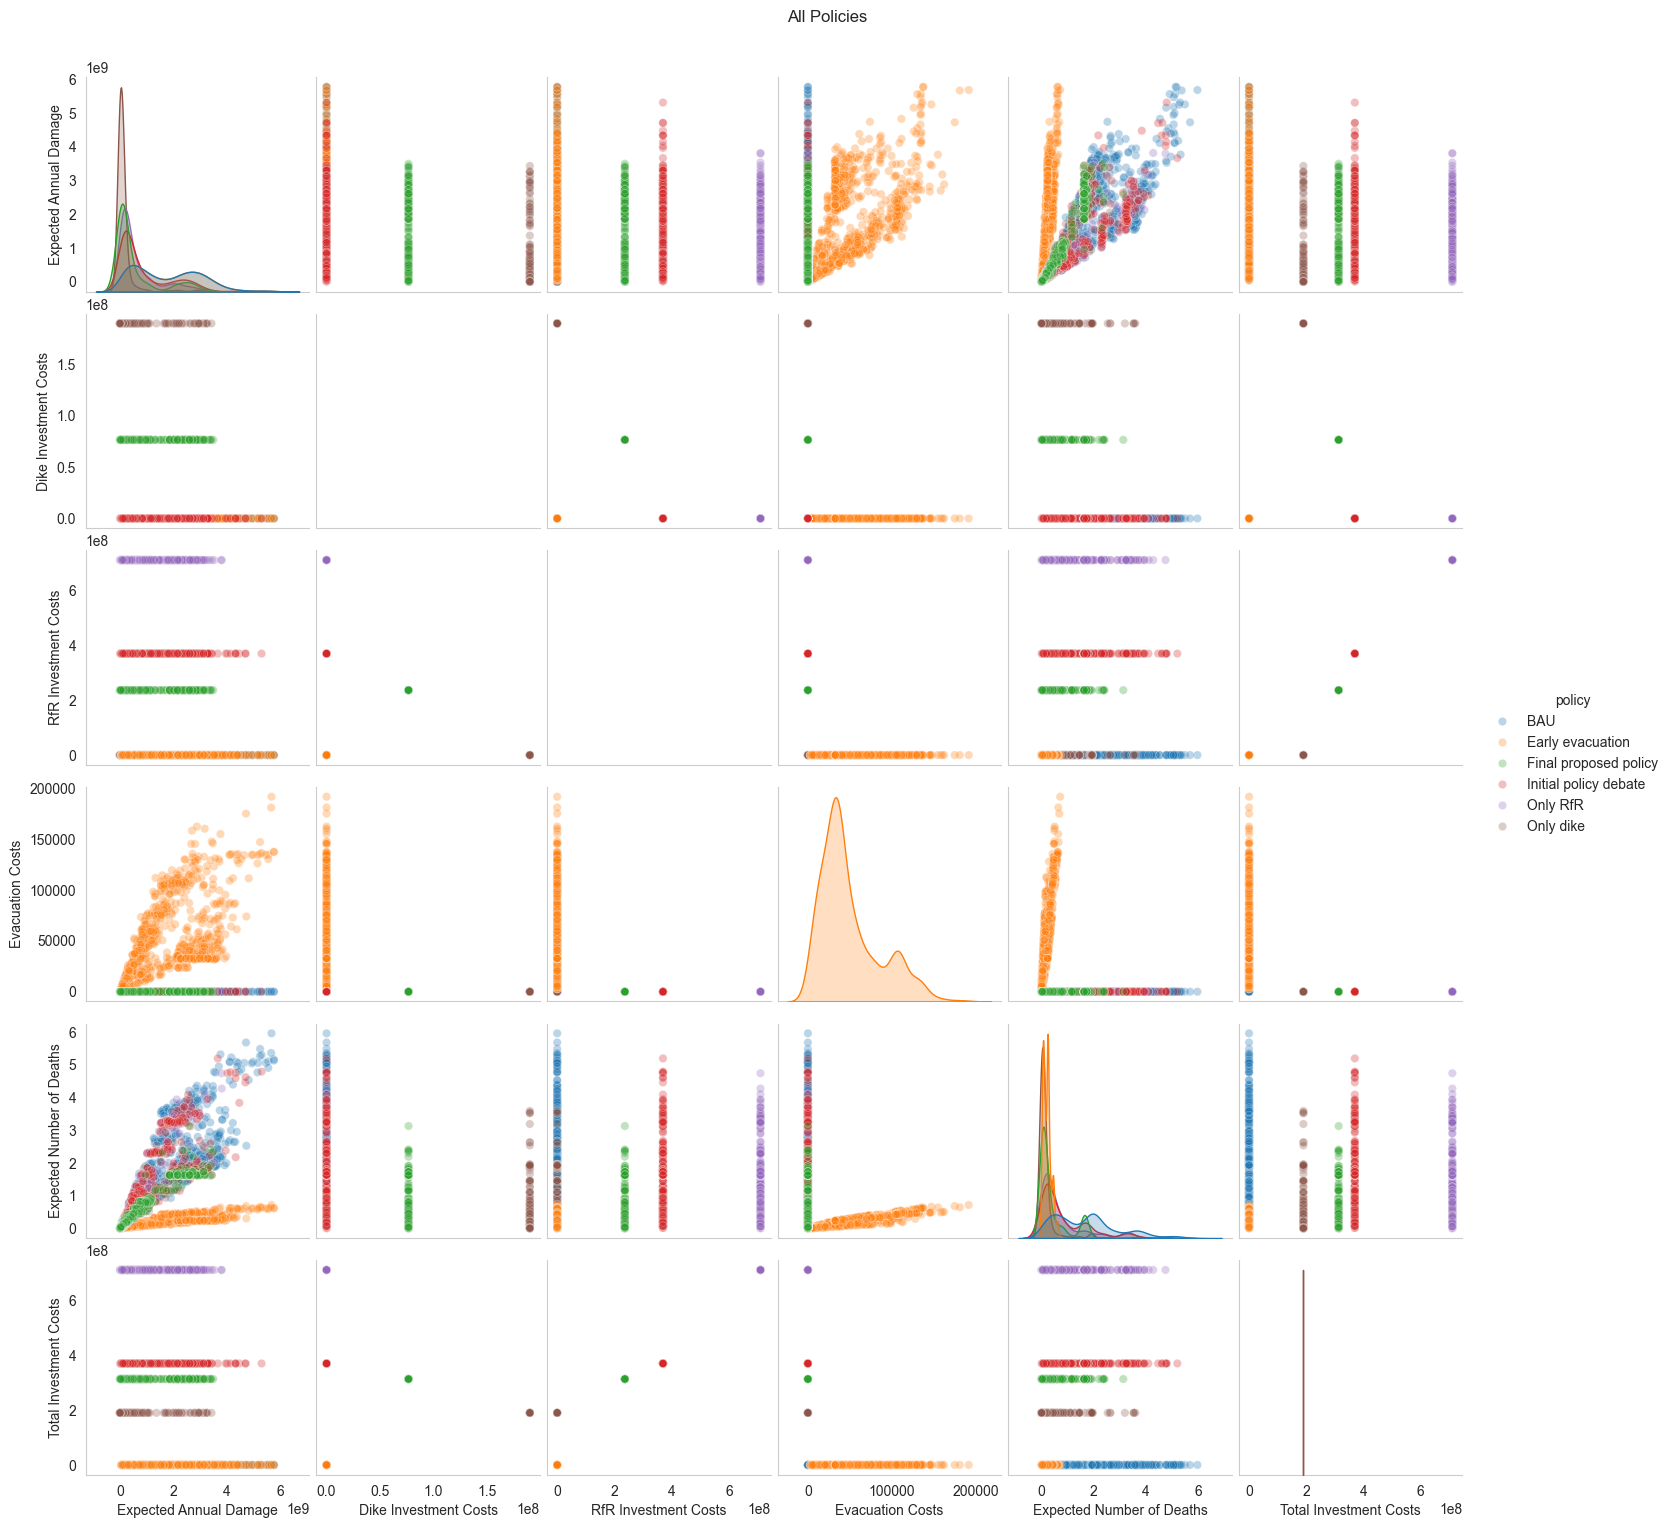

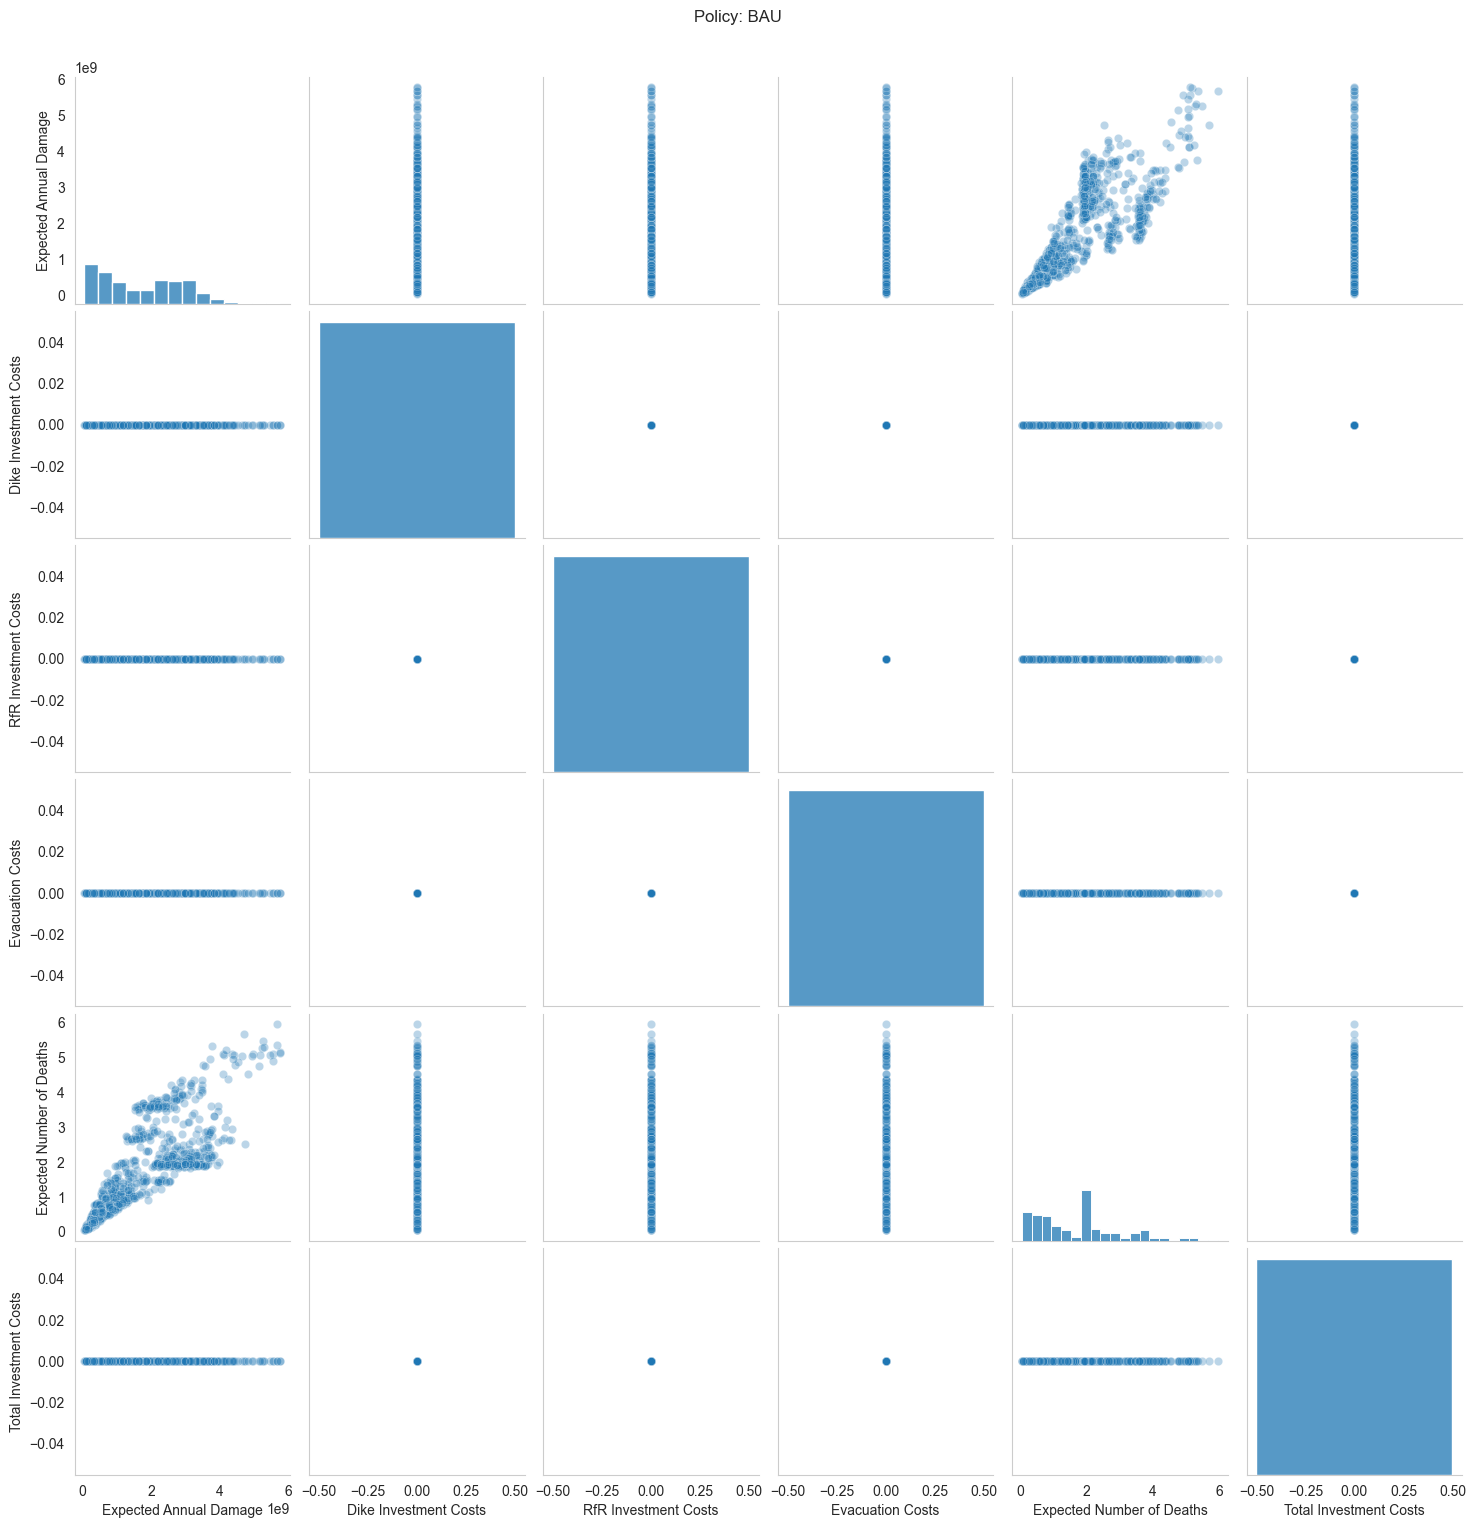

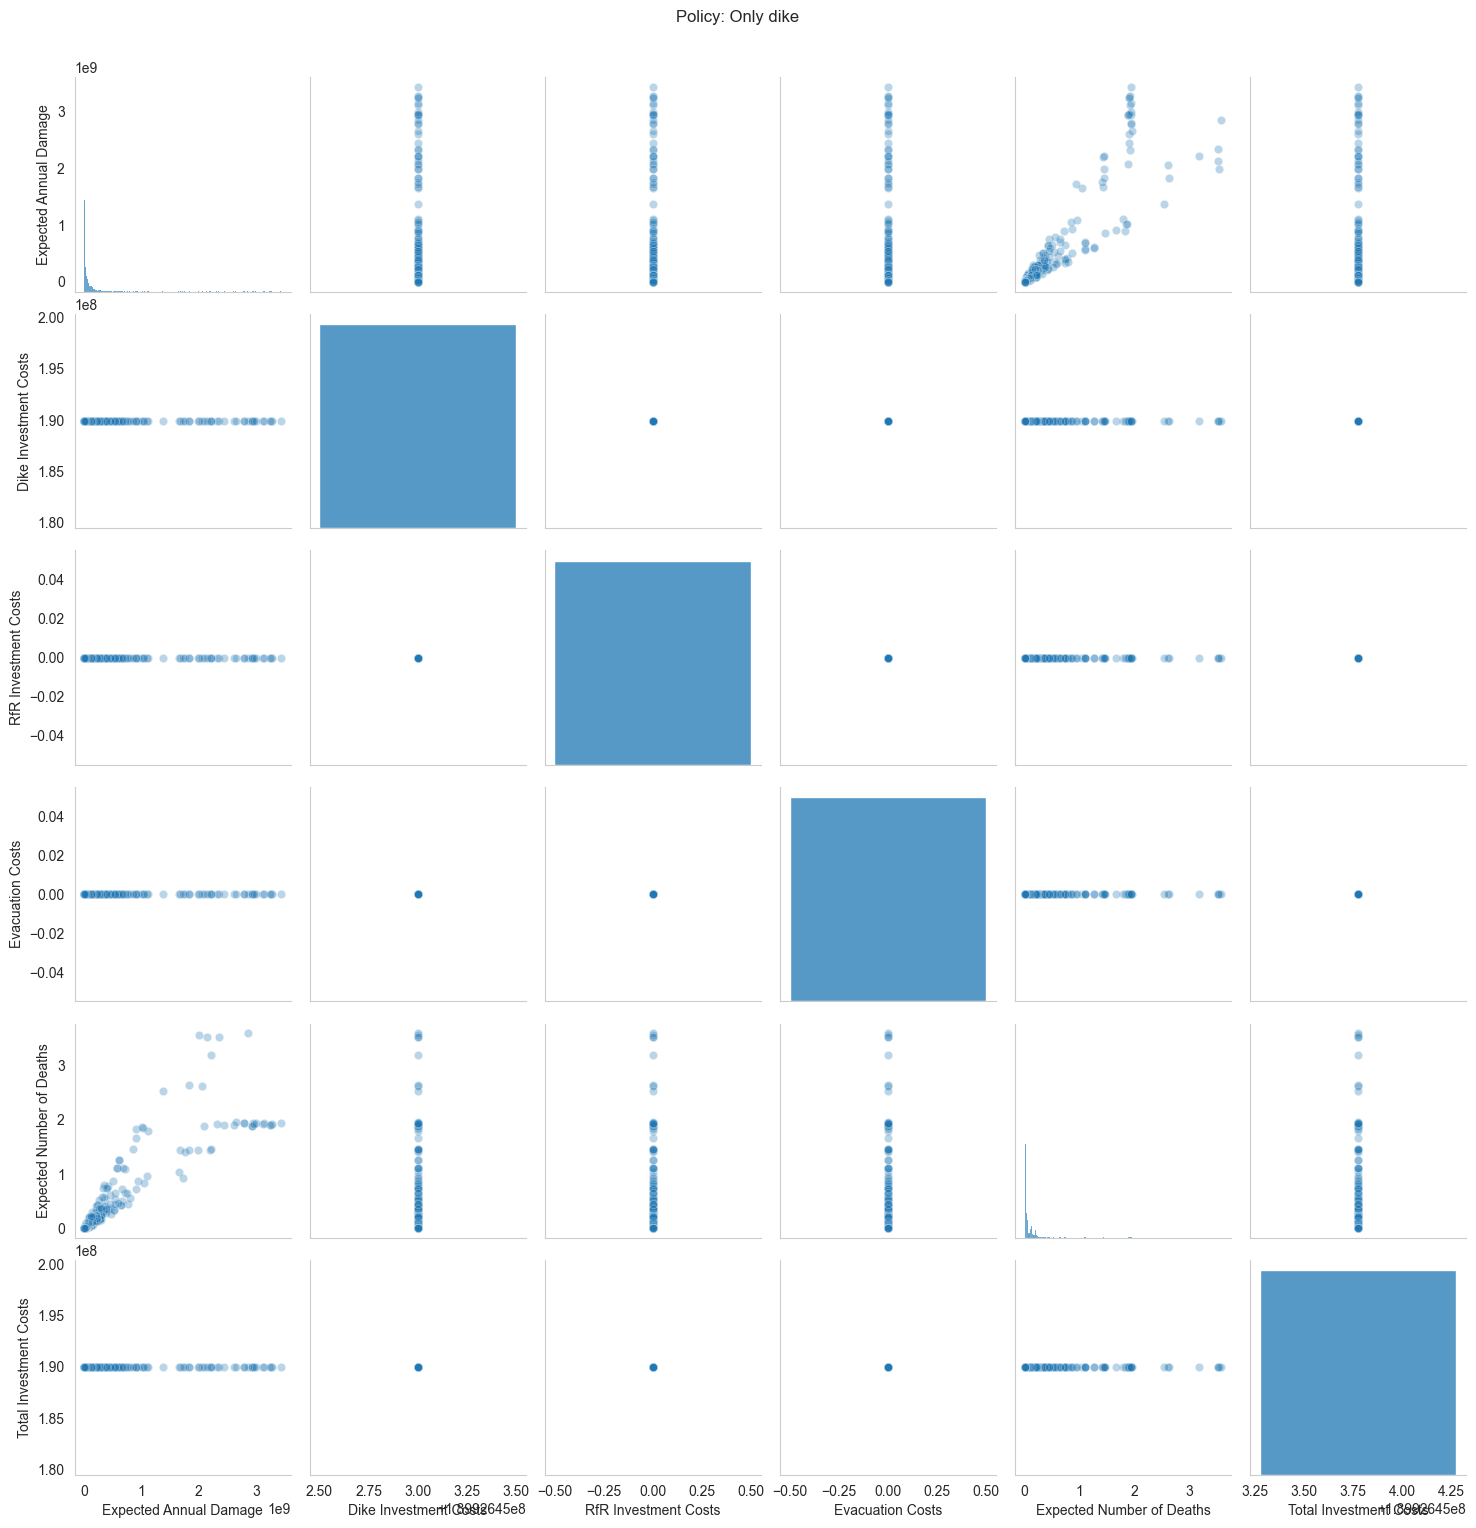

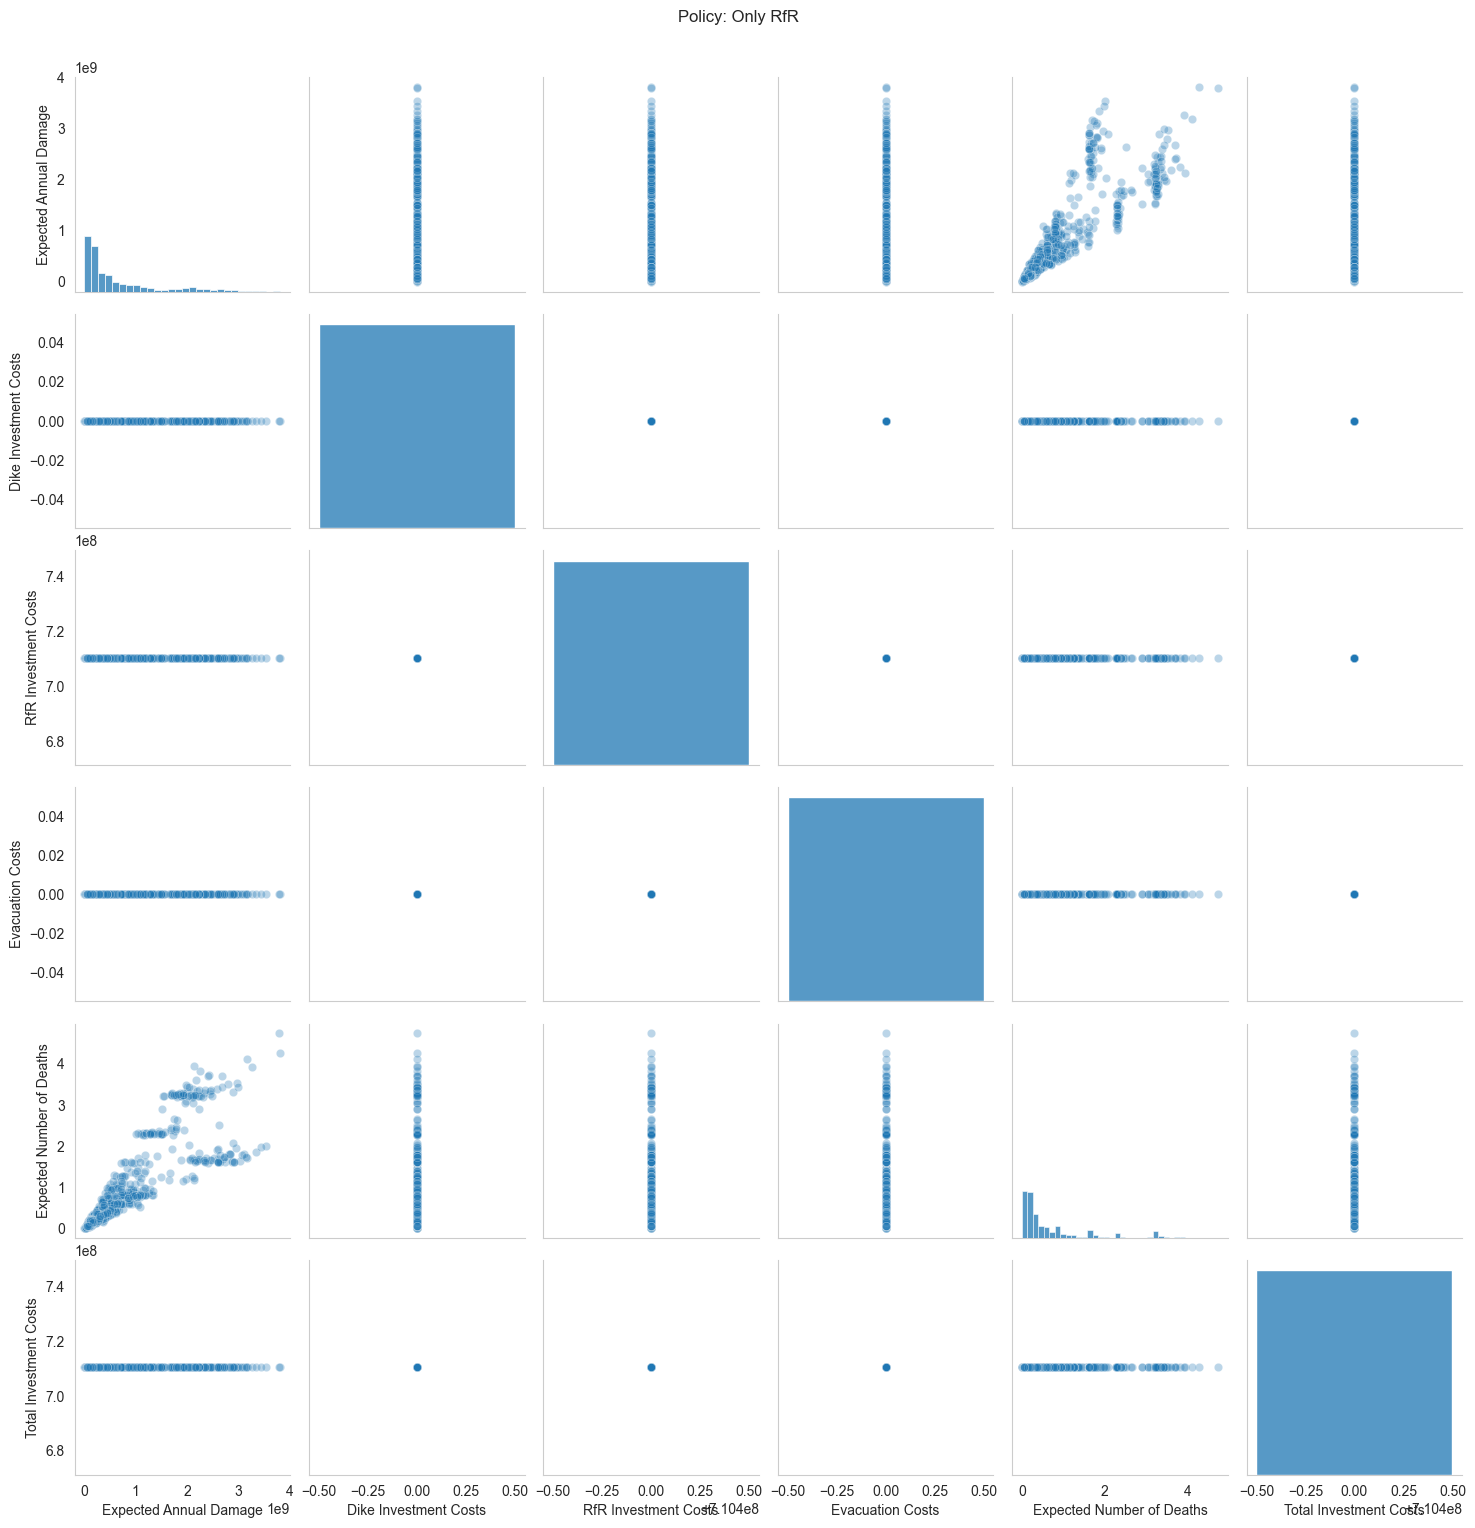

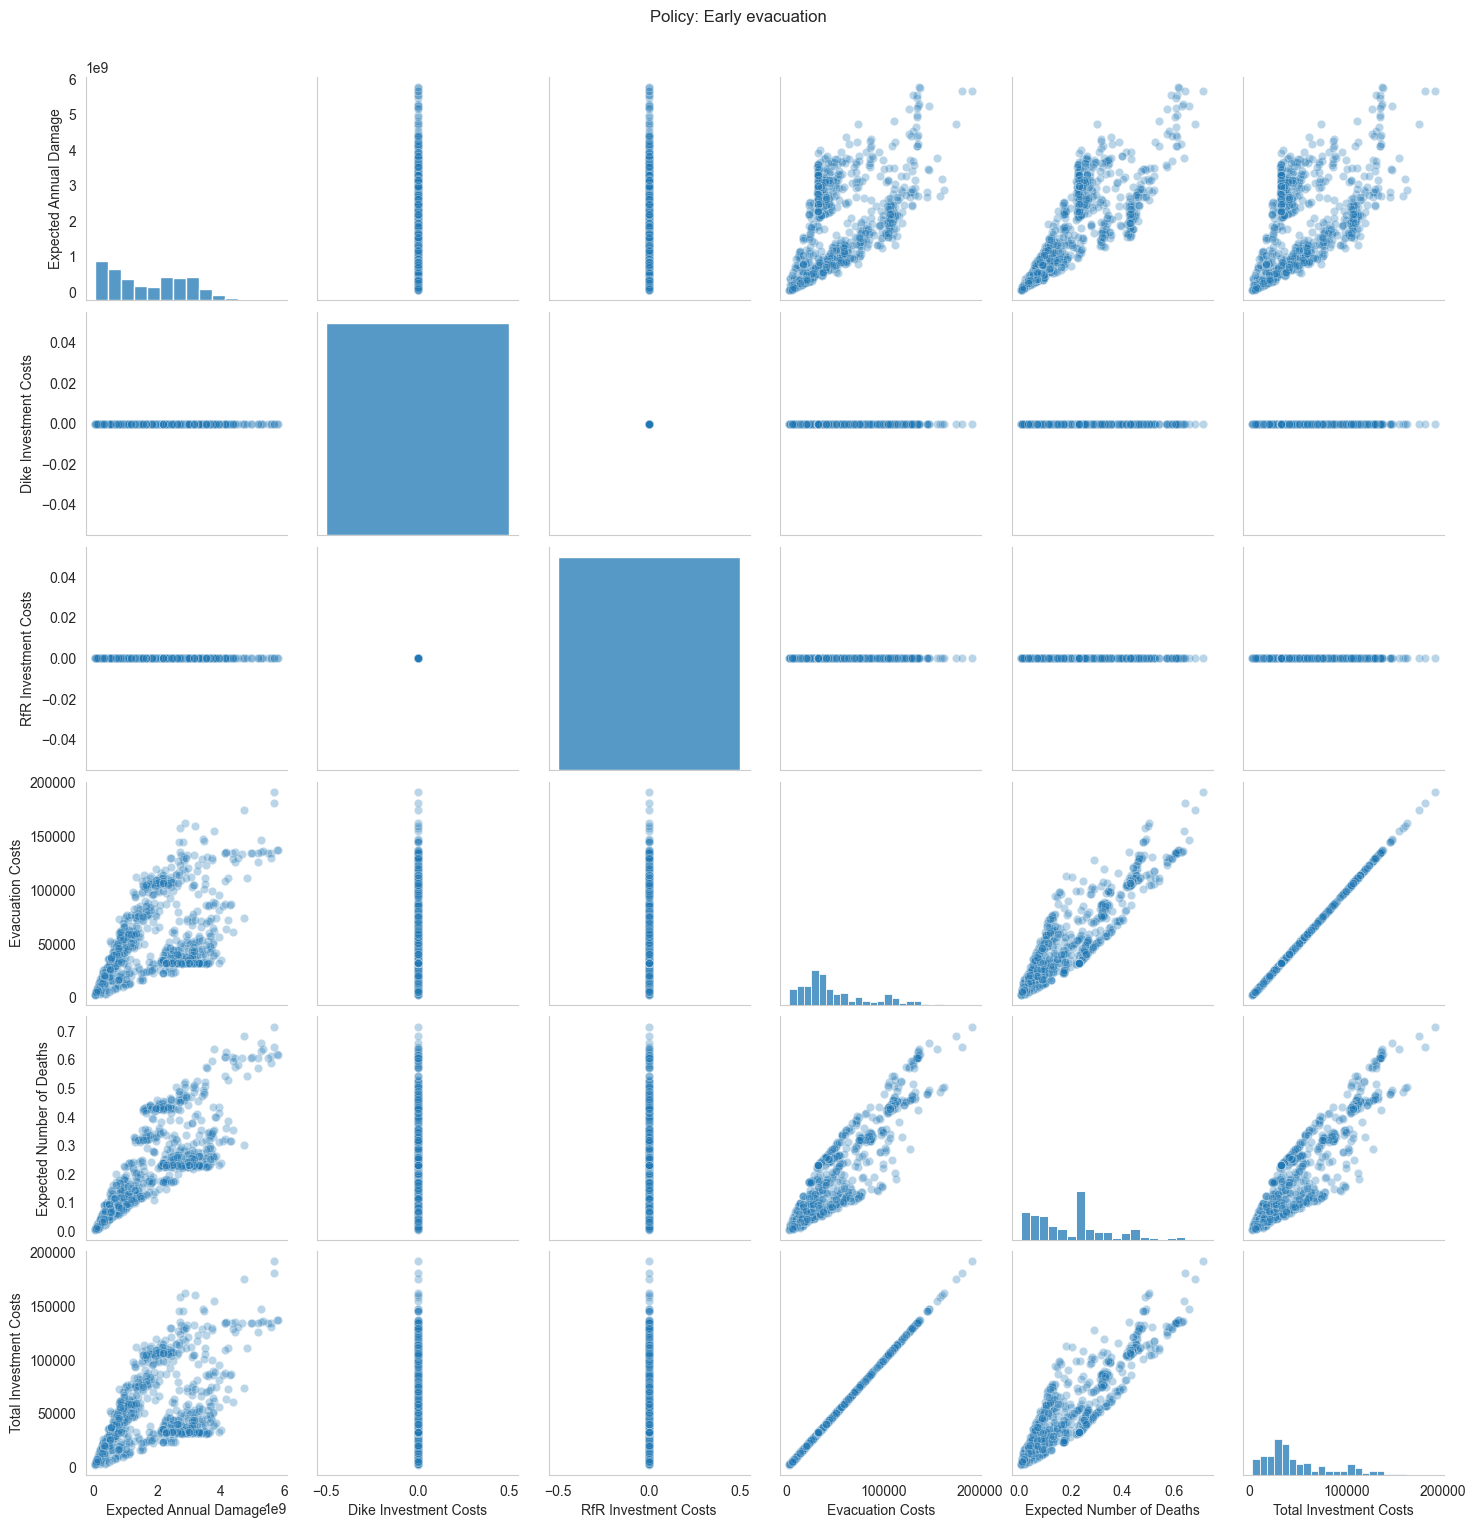

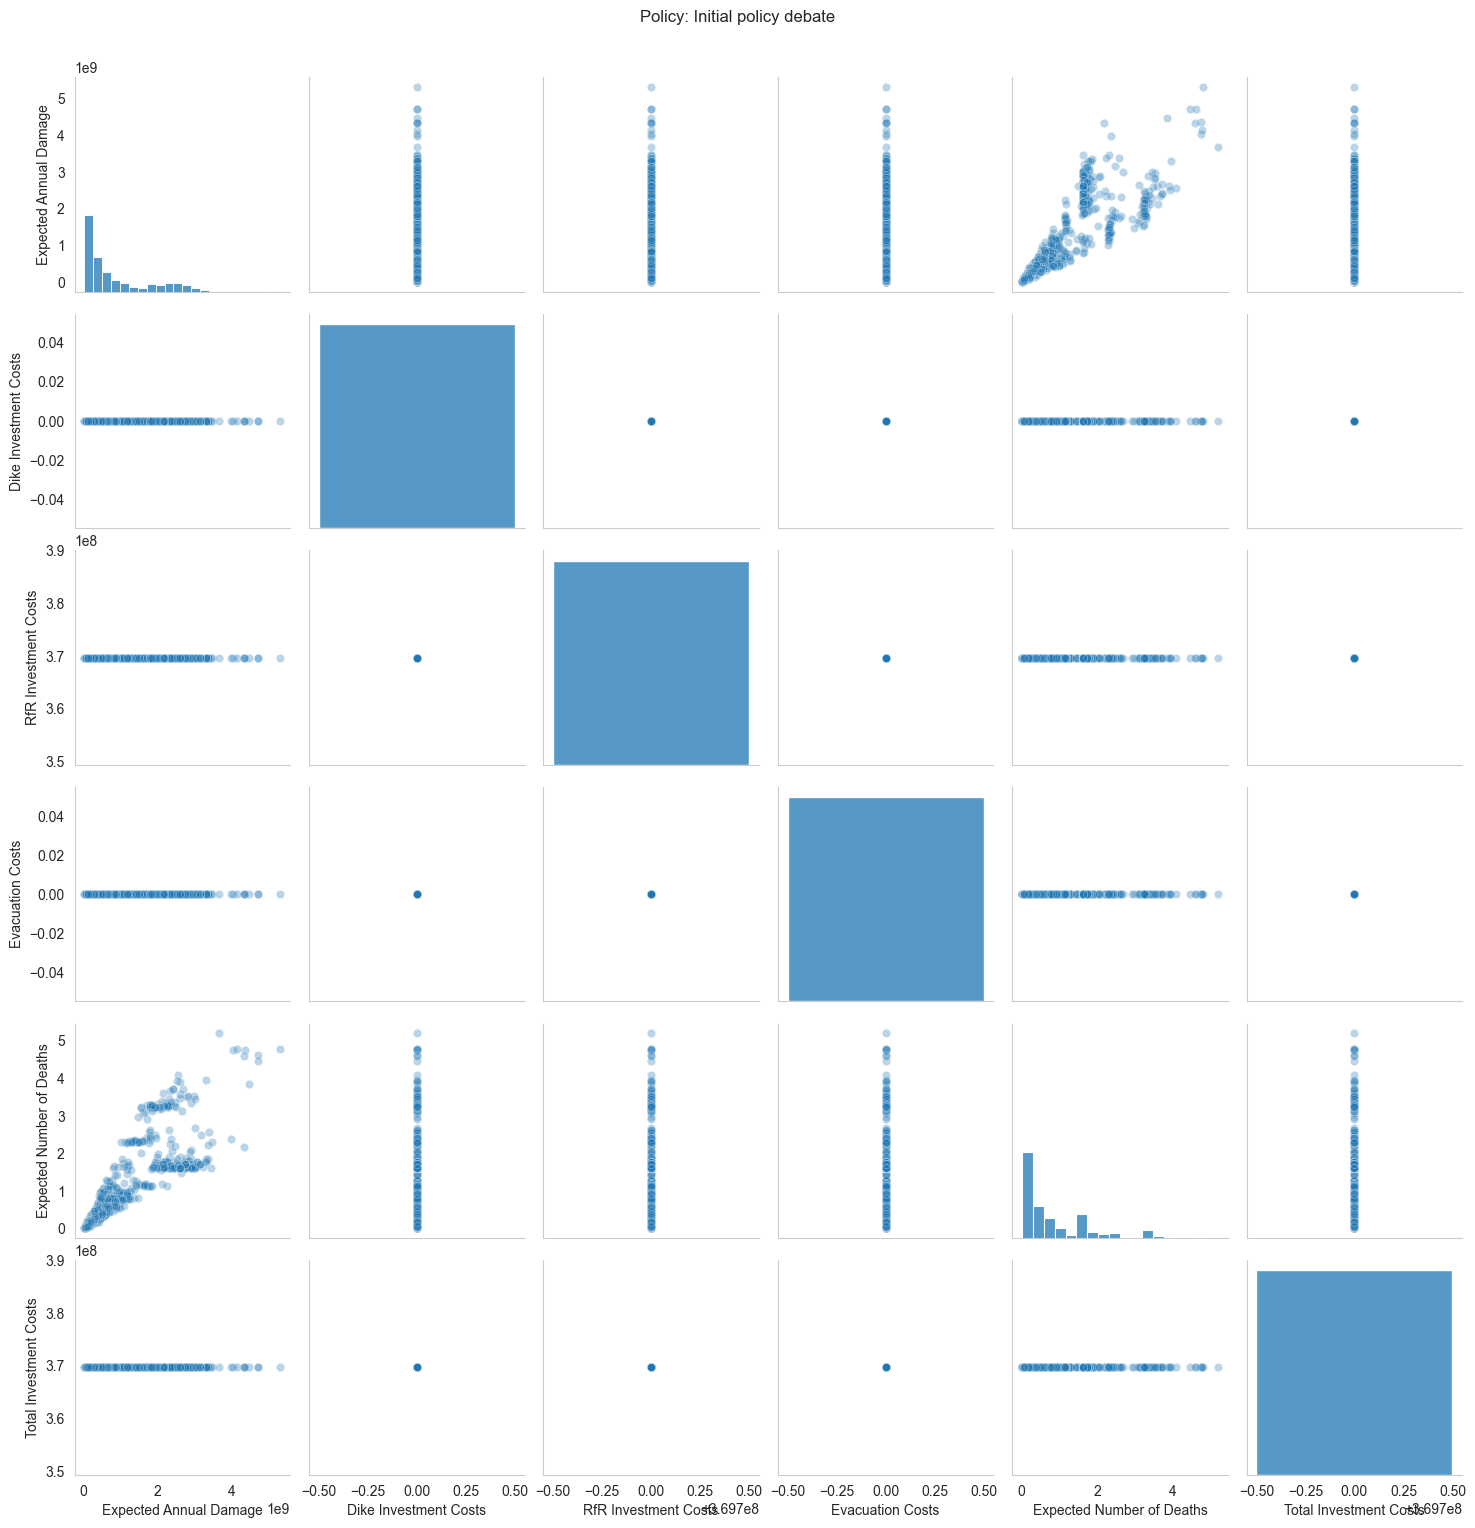

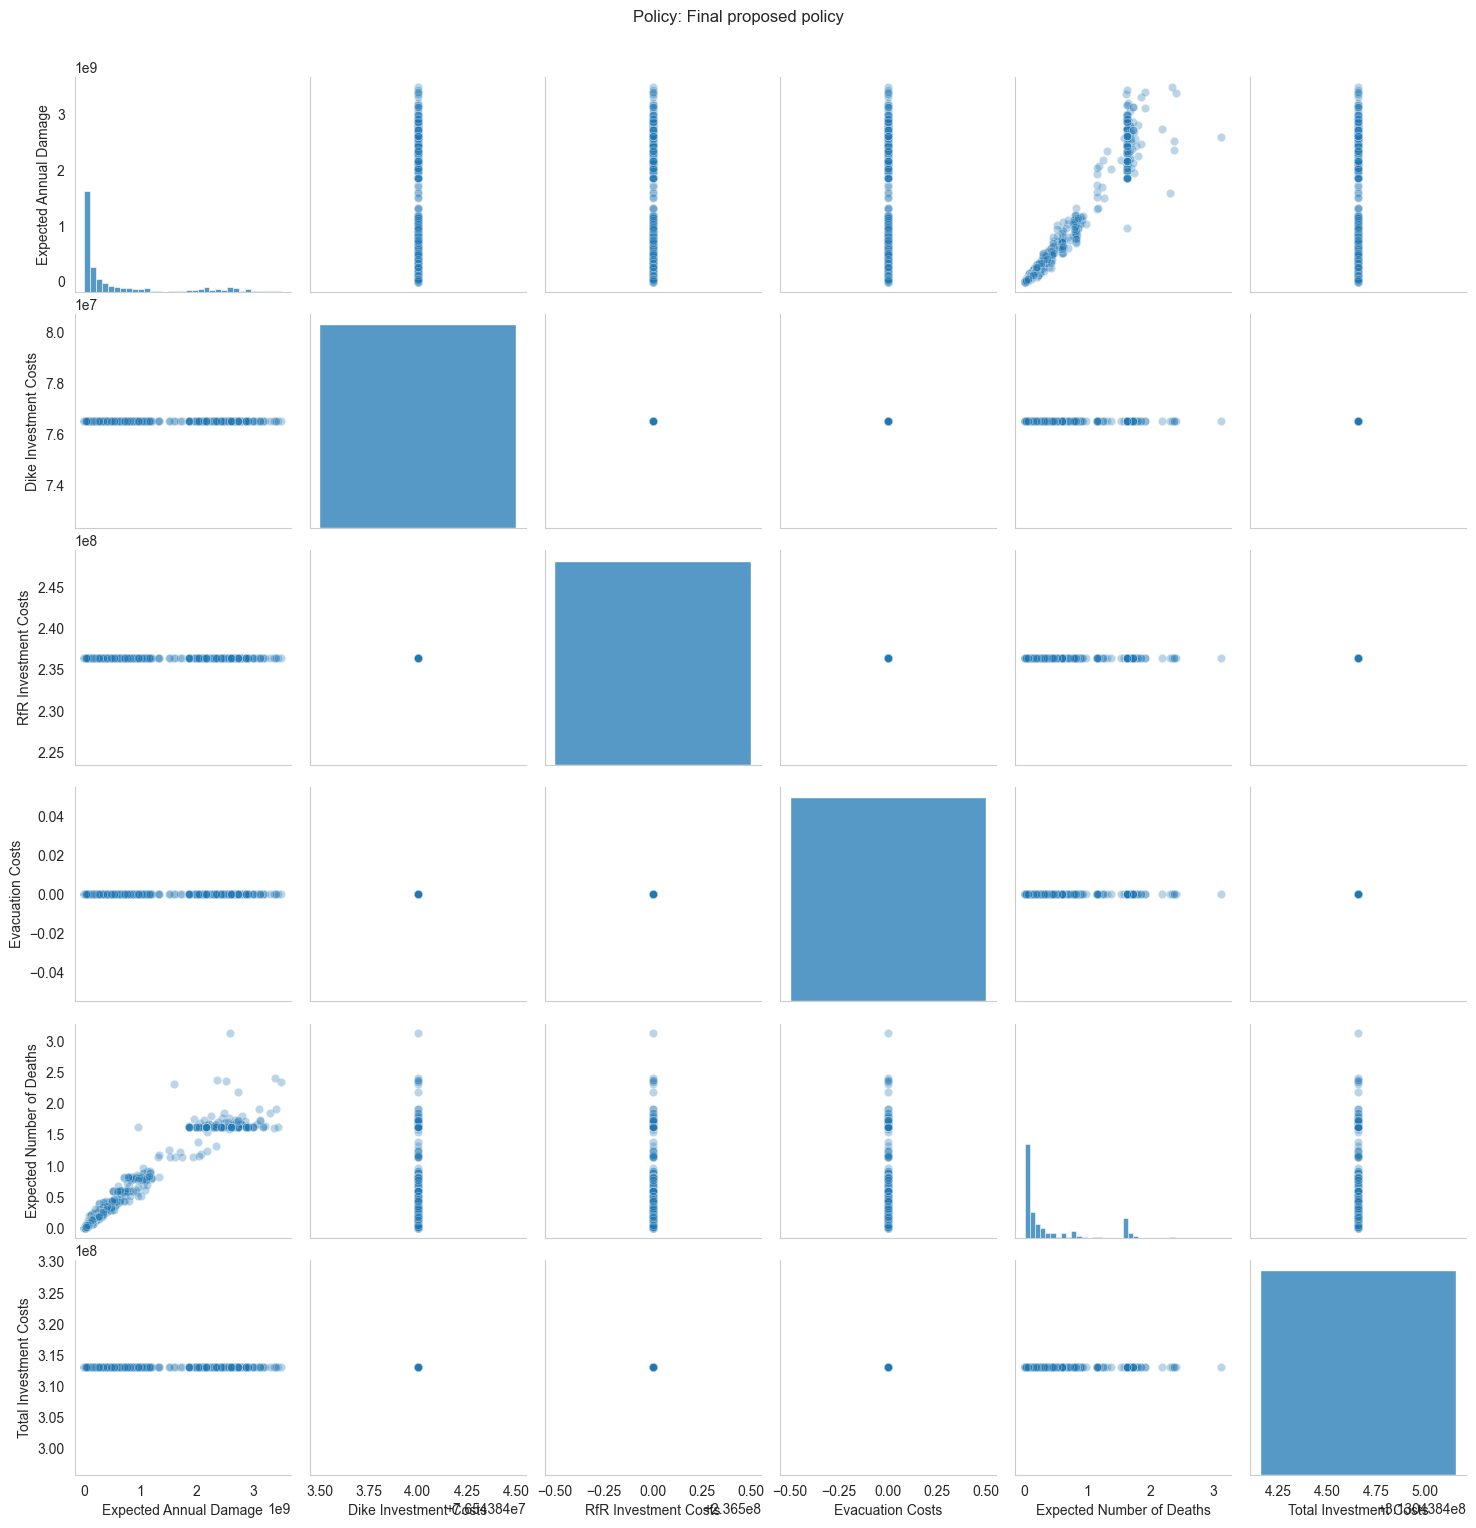

In [16]:
# Plot combined
sns.set_style("whitegrid", {'axes.grid': False})
combined_plot = sns.pairplot(data, hue='policy', vars=outcomes.keys(), plot_kws={'alpha': 0.3})
plt.suptitle('All Policies', y=1.02)
plt.show()

# Separate plots per policy
for policy_name in data['policy'].unique():
    subset = data[data['policy'] == policy_name]
    sns.set_style("whitegrid", {'axes.grid': False})
    plot = sns.pairplot(subset, vars=outcomes.keys(), plot_kws={'alpha': 0.3})
    plt.suptitle(f'Policy: {policy_name}', y=1.02)
    plt.show()